In [1]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports

In [2]:
# path
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

%cd /content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning

from train import *
from visualize_data import *
from utils import *

%cd /content/drive/My Drive/Colab Notebooks/Thesis

/content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning
/content/drive/My Drive/Colab Notebooks/Thesis


# State-Action Pair Guideline

Specify the desired state-action pair:

i.e. Before Pickup, Before Discard: Draw (bpbd_draw)

## Model Name Guideline

Specify the following parameters:

- **Data Selection**:
 - **`state-action pair`**
   - possible state-action pairs
```r
state_action_pair = {'all': 'all', # all actions
                    'bpbd': 'draw', # actions 2/3 
                    'apbd': ['discard', 'knock'], # actions 6-57, 58-109
                    'apad': 'knock_bin'}
```
 - **`model_name`**
   - name of the model based on **pruned states** and **chosen action**
 - **`numGames`**
   - Number of games used to train model
$$numGames \in [2000, 6000, 8000]$$

 - **`pruneStatesList`**
   - which states to omit when training model 
 ```r
 pruneStatesList is a list, {'currHand','topCard','deadCard','oppCard','unknownCard'}
 ```
 - **`actionChoice`**
   - which specific action to train model 
```r
actionChoice is one of {'all','draw','discard','knock'}
```
 - **`balance`** (T/F, **`default = False`**)
   - balance data by smallest class

--- 

- **Model Parameters**:

| Parameter         | Type            |Default|
| ----------------- |:---------------:| -----:|
| **batch_size**    | int             | 1000  |
| **learning_rate** | float           | 0.001 |
| **epoch**         | int             | 100   |
| **pre_train**     | bool (T/F)      | False |
| **model_PT**      | str (model/path)| null  |
| **device**        | str (cpu/cuda)  | cpu   |

# Before Pickup, Before Discard: Draw (bpbd_draw)

## all_states_draw_only

### Parameters

In [3]:
# state_action pair
state = 'bpbd'
action = 'draw'

# model name
model_name = 'all_states_draw_only'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'draw'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 100

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Create Directories

In [4]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

loading 8000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/bpbd/draw"


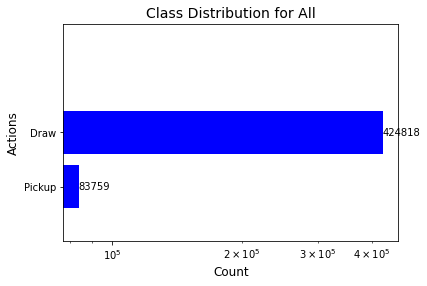

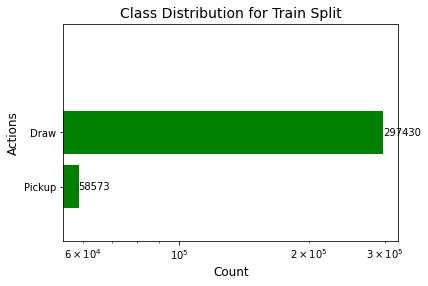

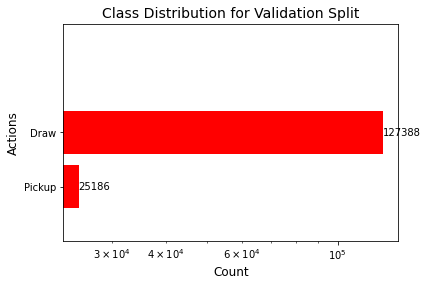

In [5]:
train_loader, val_loader, _,  classes = load_train_data(data_pth, plot_pth,
                                                        numGames, batch_size, 
                                                        pruneStatesList, actionChoice, 
                                                        balance, visualize=True)

### Train Model

Epoch: 1 | Train Loss: 0.13228763 | Train acc: 0.835510
              Val Loss: 0.12811713 |   Val acc: 0.834448
Epoch: 2 | Train Loss: 0.12623924 | Train acc: 0.835192
              Val Loss: 0.12630509 |   Val acc: 0.834782
Epoch: 3 | Train Loss: 0.12530361 | Train acc: 0.835732
              Val Loss: 0.12374892 |   Val acc: 0.835529
Epoch: 4 | Train Loss: 0.12160743 | Train acc: 0.837237
              Val Loss: 0.12123984 |   Val acc: 0.837148
Epoch: 5 | Train Loss: 0.11892710 | Train acc: 0.839190
              Val Loss: 0.11788473 |   Val acc: 0.840091
Epoch: 6 | Train Loss: 0.11724251 | Train acc: 0.841063
              Val Loss: 0.11559121 |   Val acc: 0.842634
Epoch: 7 | Train Loss: 0.11429021 | Train acc: 0.843462
              Val Loss: 0.11317084 |   Val acc: 0.844934
Epoch: 8 | Train Loss: 0.11173629 | Train acc: 0.846577
              Val Loss: 0.11086950 |   Val acc: 0.848670
Epoch: 9 | Train Loss: 0.10939110 | Train acc: 0.849771
              Val Loss: 0.10985903 |   V

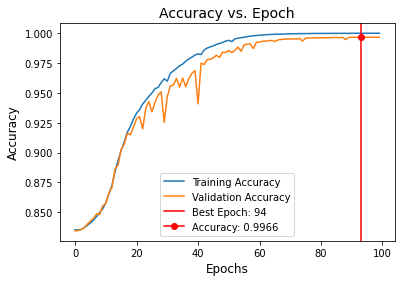

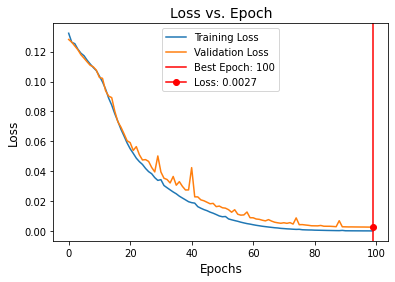

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True, pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

Accuracy: 99.99
Normalized confusion matrix


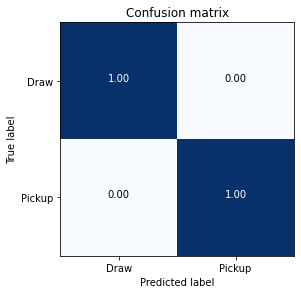

Confusion matrix, without normalization


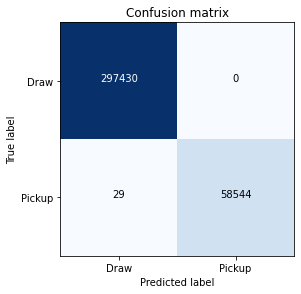

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

##### Validation Set

Accuracy: 99.65
Normalized confusion matrix


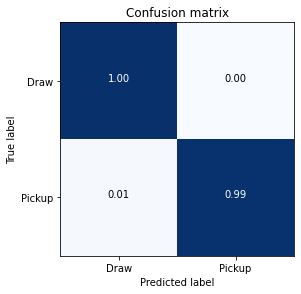

Confusion matrix, without normalization


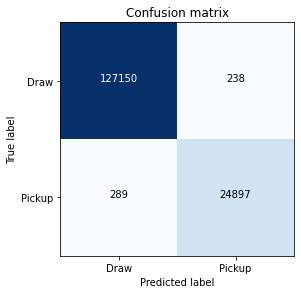

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

##### Test Set (6k)

loading 6000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/bpbd/draw
Accuracy: 99.89
Normalized confusion matrix


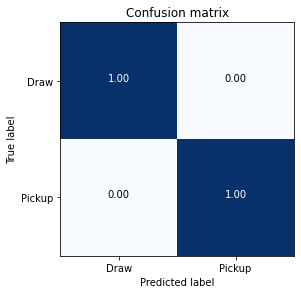

Confusion matrix, without normalization


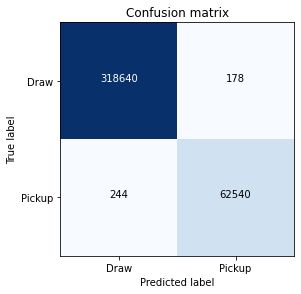

In [ ]:
currGames = 6000
test_loader_6k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)
plot_cm(plot_pth, classes, model, test_loader_6k, device, numGames=currGames)

##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/bpbd/draw


###### all epoch

Accuracy: 99.88
Normalized confusion matrix


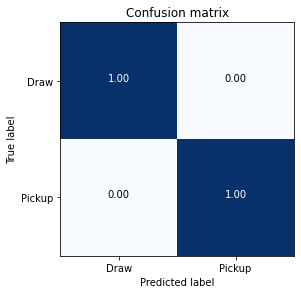

Confusion matrix, without normalization


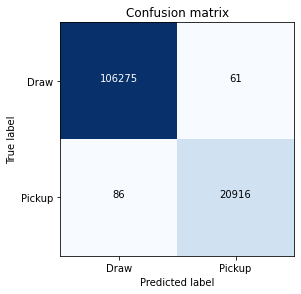

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

###### max validation accuracy

Accuracy: 99.88
Normalized confusion matrix


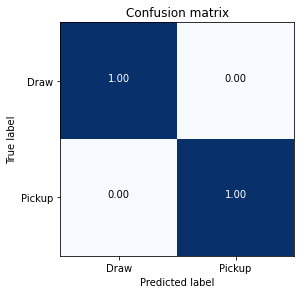

Confusion matrix, without normalization


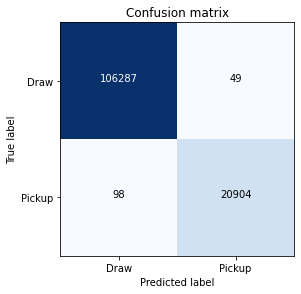

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

###### min validation loss

Accuracy: 99.88
Normalized confusion matrix


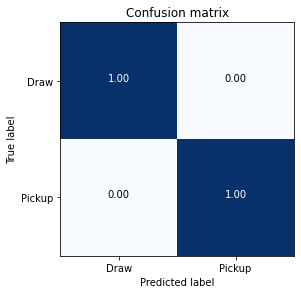

Confusion matrix, without normalization


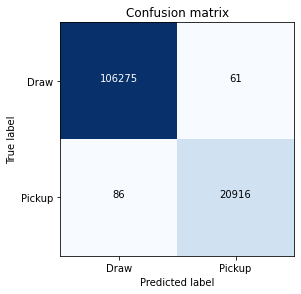

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

## all_states_all_actions

### Parameters

In [6]:
# state_action pair
state = 'bpbd'
action = 'draw'

# model name
model_name = 'all_states_all_actions'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 100

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Create Directories

In [7]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

loading 8000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/bpbd/draw"


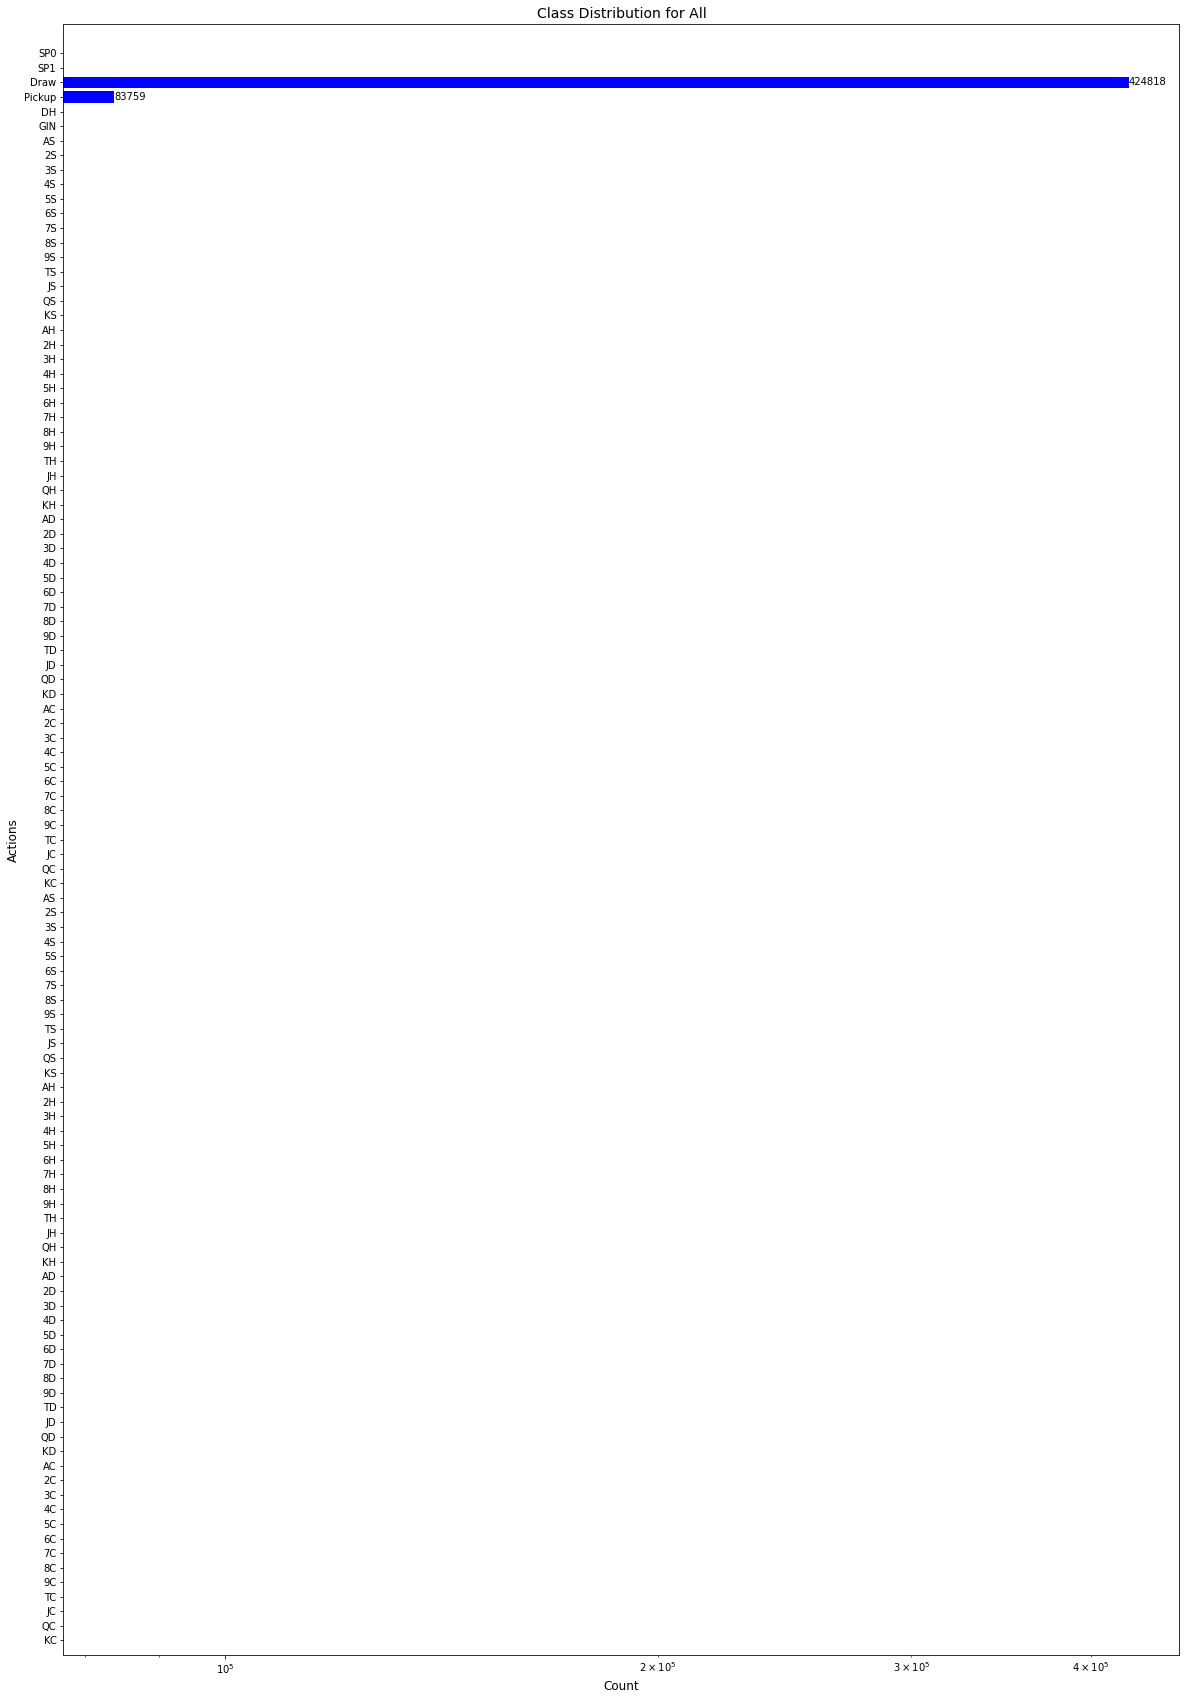

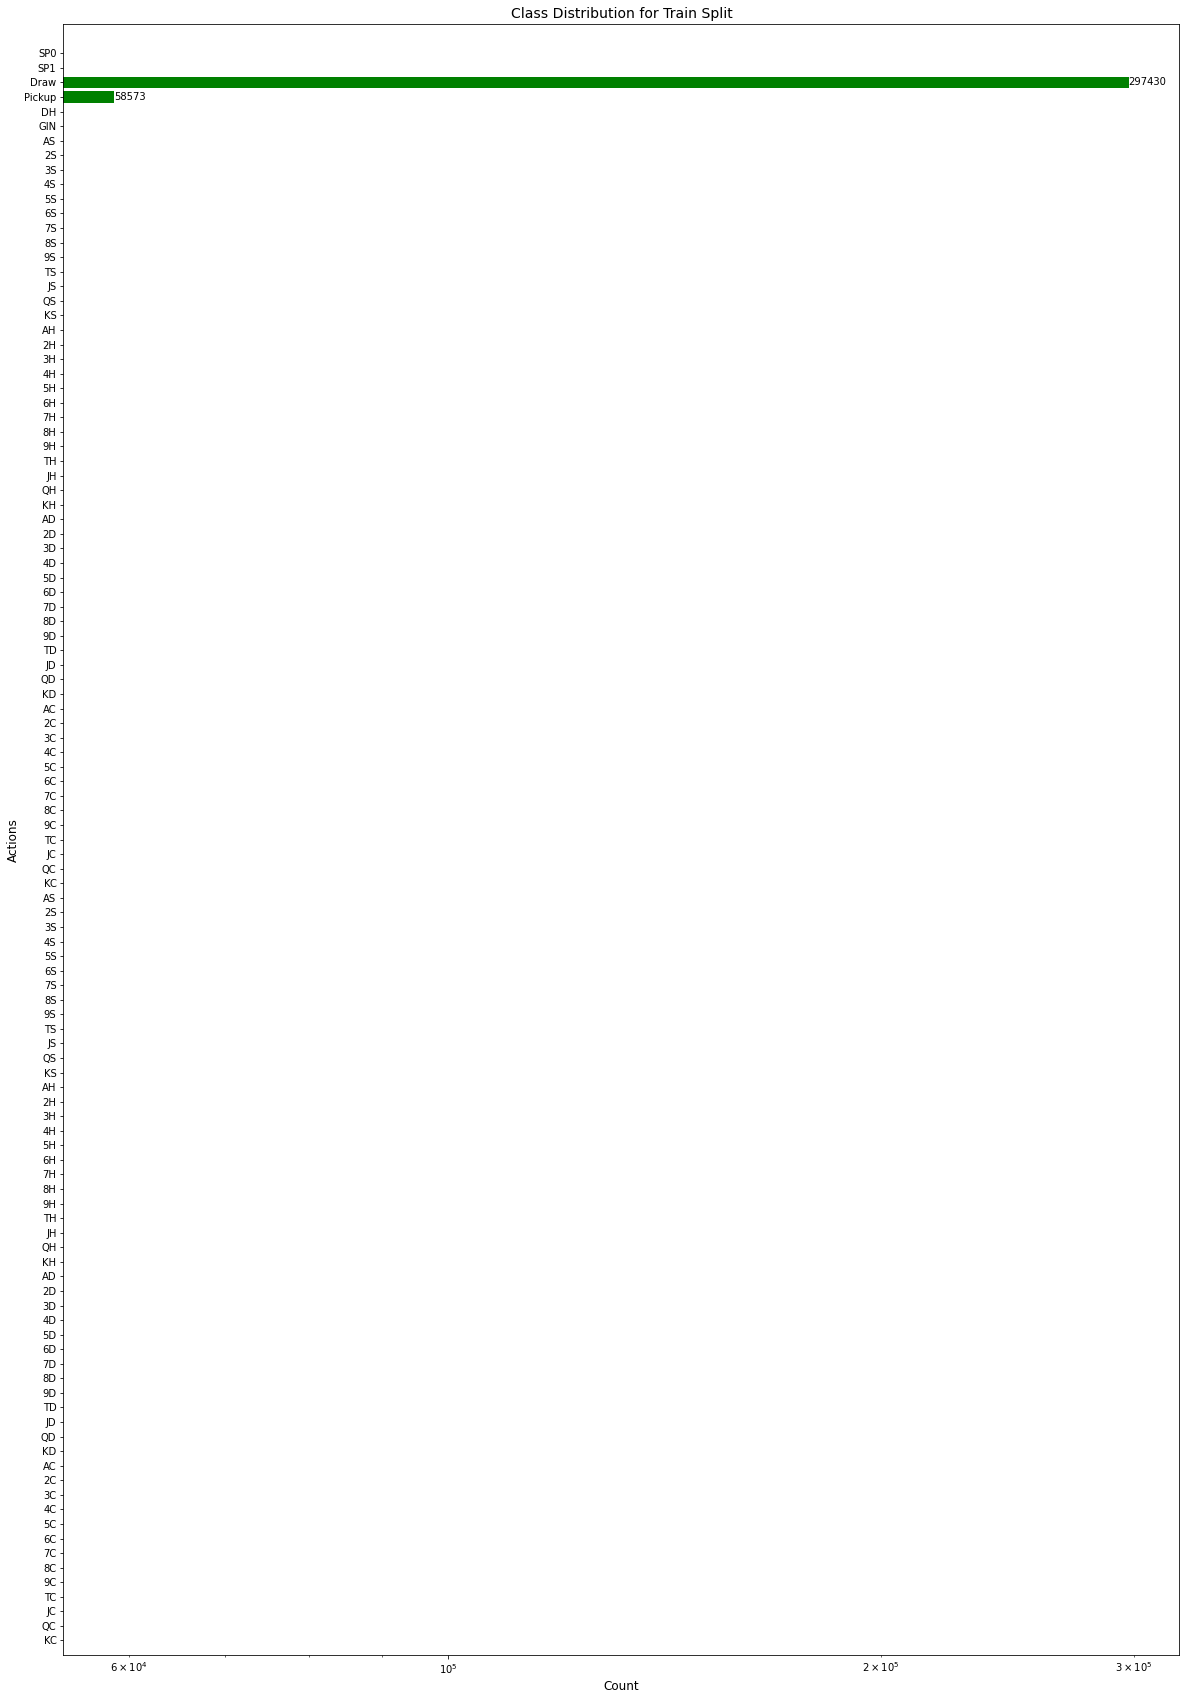

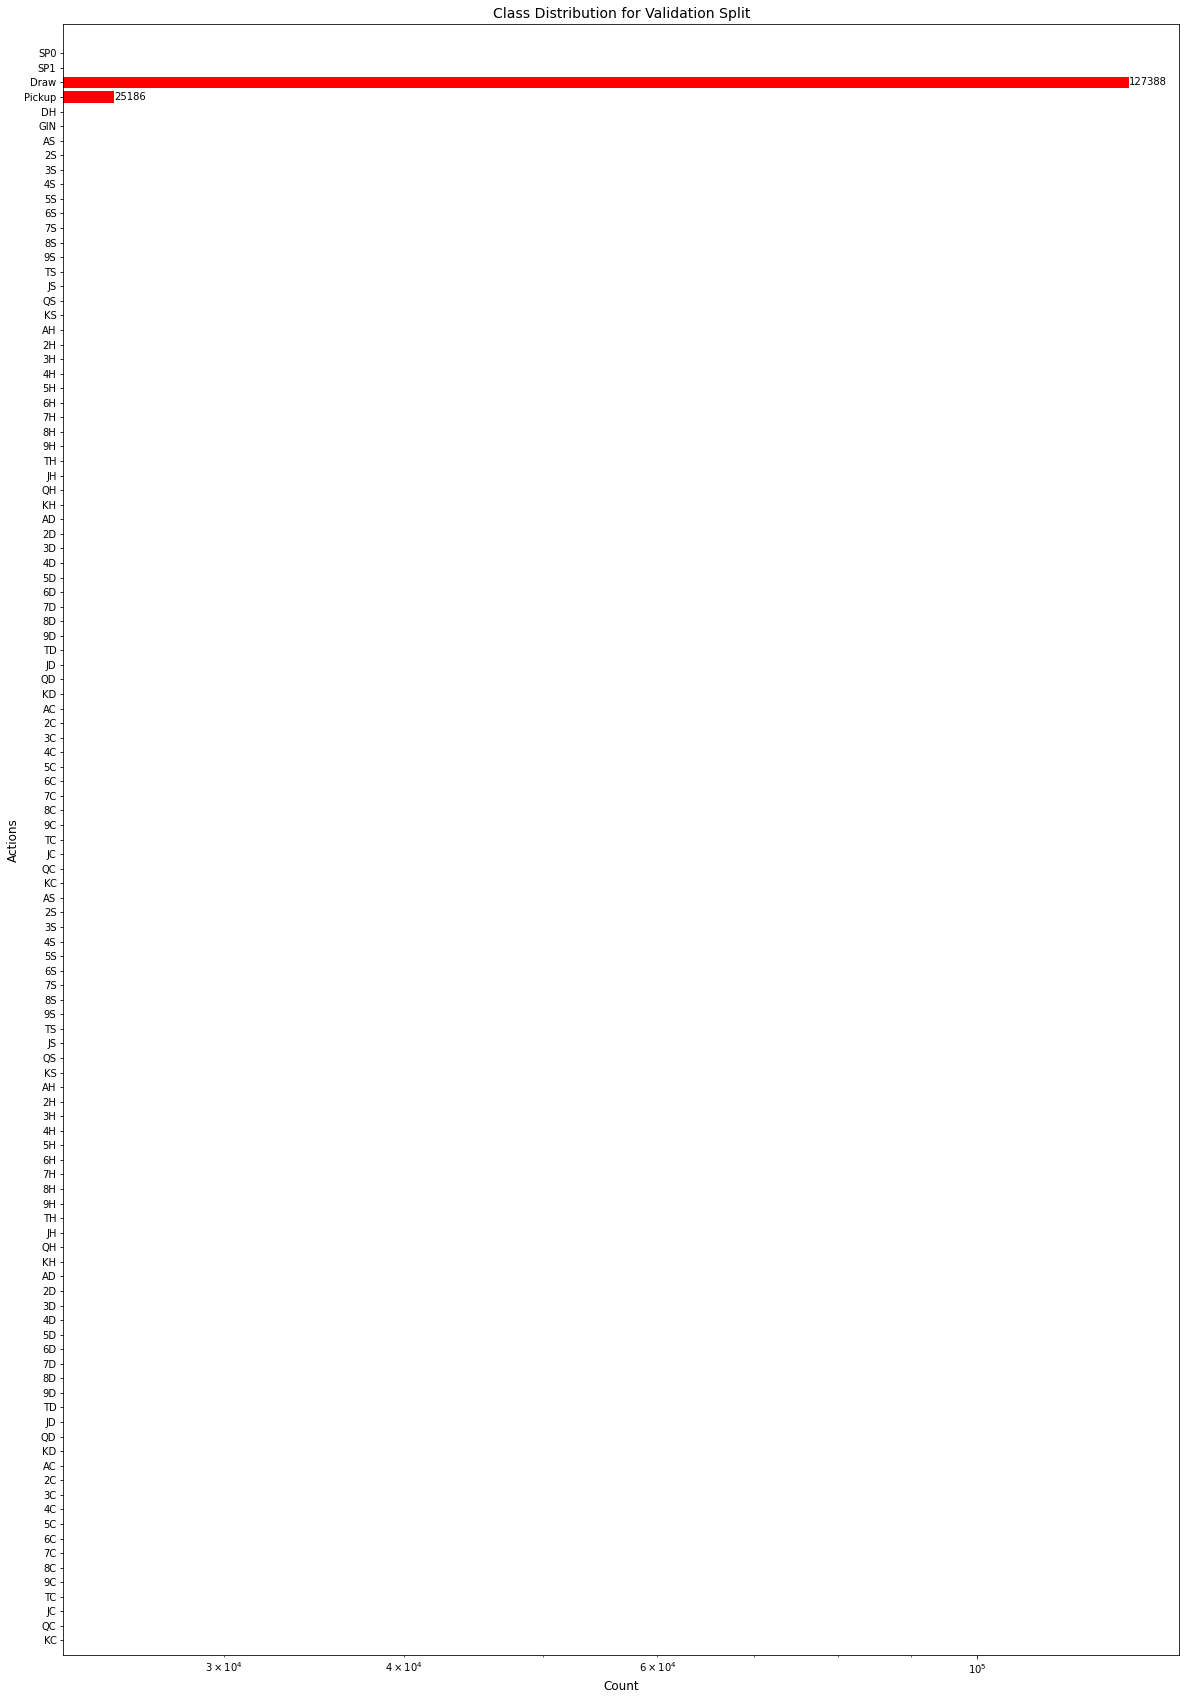

In [8]:
train_loader, val_loader, _,  classes = load_train_data(data_pth, plot_pth,
                                                        numGames, batch_size, 
                                                        pruneStatesList, actionChoice, 
                                                        balance, visualize=True)

### Train Model

Epoch: 1 | Train Loss: 0.00495582 | Train acc: 0.830749
              Val Loss: 0.00247127 |   Val acc: 0.834926
Epoch: 2 | Train Loss: 0.00239720 | Train acc: 0.835451
              Val Loss: 0.00239794 |   Val acc: 0.832947
Epoch: 3 | Train Loss: 0.00230822 | Train acc: 0.834760
              Val Loss: 0.00234589 |   Val acc: 0.834821
Epoch: 4 | Train Loss: 0.00230713 | Train acc: 0.834614
              Val Loss: 0.00235433 |   Val acc: 0.831439
Epoch: 5 | Train Loss: 0.00227930 | Train acc: 0.835212
              Val Loss: 0.00227099 |   Val acc: 0.835319
Epoch: 6 | Train Loss: 0.00225116 | Train acc: 0.836254
              Val Loss: 0.00225623 |   Val acc: 0.836086
Epoch: 7 | Train Loss: 0.00221651 | Train acc: 0.837510
              Val Loss: 0.00223442 |   Val acc: 0.836997
Epoch: 8 | Train Loss: 0.00218814 | Train acc: 0.838218
              Val Loss: 0.00218364 |   Val acc: 0.838360
Epoch: 9 | Train Loss: 0.00216565 | Train acc: 0.839133
              Val Loss: 0.00214612 |   V

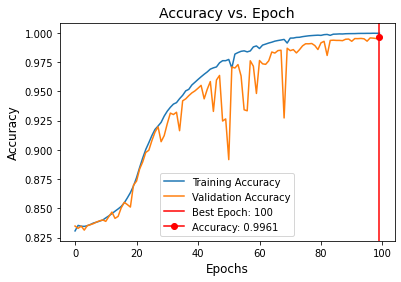

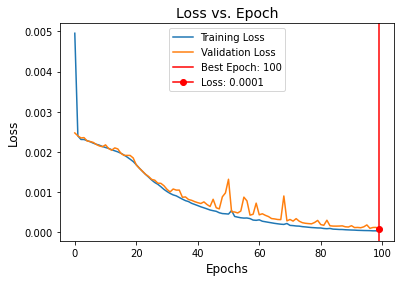

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True, pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 99.98
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 99.61
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (6k)

In [ ]:
currGames = 6000
test_loader_6k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)
plot_cm(plot_pth, classes, model, test_loader_6k, device, numGames=currGames)

loading 6000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/bpbd/draw
Accuracy: 99.86
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/bpbd/draw


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 99.87
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 99.87
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 99.87
Normalized confusion matrix
Confusion matrix, without normalization
